In [1]:
import pandas as pd
import numpy as np
from ortools.linear_solver import pywraplp
from ortools.sat.python import cp_model
import json
import collections
import copy
import matplotlib.pyplot as plt
import subprocess

assignment = pd.read_csv("assignment.csv")
distances = pd.read_csv("brick_rp_distances.csv")
workload = pd.read_csv("bricks_index_values.csv")

In [2]:
def str_to_list(to_cast):
    return json.loads(to_cast)

In [3]:
def create_init_assign_matrix(assignments):
    assignment_d = {}
    for i in range(4):
        x = assignment[assignment["SR#"] == (i+1)]
        for brick in str_to_list(x["Bricks_Assigned"][i]):
            assignment_d[brick] = i + 1
    sorted_dict = dict(sorted(assignment_d.items()))
    matrix = [[int((i+1) == sorted_dict[k])for i in range(4)] for k in sorted_dict.keys()]
    return matrix

In [4]:
def create_index_value_matrix(bricks_index_values):
    index_dict = bricks_index_values.set_index("brick").T.to_dict('list')
    sorted_dict = dict(sorted(index_dict.items()))
    return [[float(sorted_dict[index][0]), float(sorted_dict[index][0]), float(sorted_dict[index][0]), float(sorted_dict[index][0])] for index in sorted_dict.keys()]

In [5]:
def create_distances_matrix(distances):
    distances_dict = distances.set_index("brick").T.to_dict('list')
    sorted_dict = dict(sorted(distances_dict.items()))
    return [sorted_dict[index] for index in sorted_dict.keys()]

In [6]:
def print_solution(sol):
    for brick in range(len(sol)):
        print(f"{brick + 1} : {[sol[brick][sr] for sr in range(len(sol[0]))]}")

In [7]:
def compute_reassignments(init, solution):
    return 1/2*sum([init[brick][sr] - 2*init[brick][sr]*solution[brick][sr] + solution[brick][sr] for brick in range(len(init)) for sr in range(len(init[0]))])

In [8]:
def compute_total_distances(distances_m, solution):
    dist = 0
    for sr in range(len(distances_m[0])):
        for brick in range(len(distances_m)):
            dist += distances_m[brick][sr] * solution[brick][sr]
    return dist

In [9]:
def print_reassignments(init, solution):
    for brick in range(len(init)):
        first_sr = -1
        second_sr = -1
        for sr in range(len(init[0])):
            if init[brick][sr] - solution[brick][sr] == 1:
                first_sr = sr
            if init[brick][sr] - solution[brick][sr] == -1:
                second_sr = sr
        if first_sr != -1 and second_sr != -1:
            print(f"Brick {brick + 1} has changed from SR {first_sr + 1} to SR {second_sr + 1}")

In [10]:
def print_distance_by_sr(distances_m, solution):
    for sr in range(len(distances_m[0])):
        dist = 0
        for brick in range(len(distances_m)):
            dist += distances_m[brick][sr] * solution[brick][sr]
        print(f"SR {sr + 1} is travelling {dist}km")

In [11]:
def print_workload_by_sr(workload_m, solution):
    for sr in range(len(workload_m[0])):
        wl = 0
        for brick in range(len(workload_m)):
            wl += workload_m[brick][sr] * solution[brick][sr]
        print(f"SR {sr + 1} is working {wl}")

In [12]:
def compute_diff_min_max_workload(workload_m, solution):
    wlb = 0
    wlh = 0
    for sr in range(len(workload_m[0])):
        wl = 0
        for brick in range(len(workload_m)):
            wl += workload_m[brick][sr] * solution[brick][sr]
        if wlb == 0 and wlh == 0:
            wlb = wl
            wlh = wl
        else:
            if wlb > wl:
                wlb = wl
            if wlh < wl:
                wlh = wl
    return wlh - wlb

# Q1 & Q2

In [14]:
# Create linear solver
solver = pywraplp.Solver.CreateSolver("SCIP")
if not solver:
    print("Error during solver's creation")

In [15]:
# Values for constraints
epsilon = 0.1
min_workload = 0.8
max_workload = 1.2
init_state_matrix = create_init_assign_matrix(assignment)
index_value_matrix = create_index_value_matrix(workload)
distances_matrix = create_distances_matrix(distances)
hq_bricks = [[0,3],[1,13],[2,15],[3,21]]
num_sr = len(distances_matrix[0])
num_bricks = len(distances_matrix)

# Boolean variables
x = {}
for brick in range(num_bricks):
    for sr in range(num_sr):
        x[brick, sr] = solver.IntVar(0, 1, f"x[{brick},{sr}]")

# Add constraints
# One brick to one SR and one SR to one brick
for brick in range(num_bricks):
    solver.Add(solver.Sum(x[brick, sr] for sr in range(num_sr)) == 1)

# The cental brick for an SR cannot change
hq_vars = []
for hq in hq_bricks:
    hq_vars.append(x[hq[1],hq[0]])
solver.Add(solver.Sum(hq_vars) == num_sr)

# Balance workload (min and max)
for sr in range(num_sr):
    solver.Add(solver.Sum(index_value_matrix[brick][sr] * x[brick,sr] for brick in range(num_bricks)) >= min_workload)
    solver.Add(solver.Sum(index_value_matrix[brick][sr] * x[brick,sr] for brick in range(num_bricks)) <= max_workload)

In [16]:
solutions = {}
feasible = True
loop = 0
while feasible:
    if loop % 2:
        if loop != 0:
            solver.Add(solver.Sum((x[brick,sr] - 2*init_state_matrix[brick][sr]*x[brick,sr] + init_state_matrix[brick][sr]) * 1/2 for brick in range(num_bricks) for sr in range(num_sr)) <= solutions[loop-1][2] - epsilon)
        solver.Minimize(
            solver.Sum((x[brick,sr] - 2*init_state_matrix[brick][sr]*x[brick,sr] + init_state_matrix[brick][sr]) * 1/2  for brick in range(num_bricks) for sr in range(num_sr))
        )
    else:
        if loop != 0:
            solver.Add(solver.Sum(distances_matrix[brick][sr] * x[brick,sr] for sr in range(num_sr) for brick in range(num_bricks)) <= solutions[loop-1][1] - epsilon)
        solver.Minimize(
            solver.Sum(distances_matrix[brick][sr] * x[brick,sr] for sr in range(num_sr) for brick in range(num_bricks))
        )

    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        print(f"################## LOOP {loop + 1} ###################") 
        solution = [[x[brick,sr].solution_value() for sr in range(num_sr)] for brick in range(num_bricks)]
        print_reassignments(init_state_matrix, solution)
        print()
        print("======DISTANCES======")
        print_distance_by_sr(distances_matrix, solution)
        print()
        print("======WORKLOAD======")
        print_workload_by_sr(index_value_matrix, solution)
        print()
        print(f"Number of reassignments : {compute_reassignments(init_state_matrix, solution)}")
        print(f"Total distance : {compute_total_distances(distances_matrix, solution)}")
        print(f"Diff min max workload : {compute_diff_min_max_workload(index_value_matrix, solution)}")
        print()
        solutions[loop] = [solution, compute_total_distances(distances_matrix, solution), compute_reassignments(init_state_matrix, solution), compute_diff_min_max_workload(index_value_matrix, solution)]
    else:
        if status == 2:
            feasible = False
    loop += 1

################## LOOP 1 ###################
Brick 9 has changed from SR 3 to SR 1
Brick 10 has changed from SR 2 to SR 3
Brick 12 has changed from SR 2 to SR 1
Brick 15 has changed from SR 1 to SR 3
Brick 18 has changed from SR 3 to SR 2
Brick 19 has changed from SR 4 to SR 1
Brick 20 has changed from SR 4 to SR 1

======DISTANCES======
SR 1 is travelling 64.37km
SR 2 is travelling 7.559999999999999km
SR 3 is travelling 6.5600000000000005km
SR 4 is travelling 76.13km

======WORKLOAD======
SR 1 is working 1.0375999999999999
SR 2 is working 1.0447
SR 3 is working 1.1149
SR 4 is working 0.8028000000000001

Number of reassignments : 7.0
Total distance : 154.62
Diff min max workload : 0.31209999999999993

################## LOOP 2 ###################
Brick 10 has changed from SR 2 to SR 3

======DISTANCES======
SR 1 is travelling 19.3km
SR 2 is travelling 28.800000000000004km
SR 3 is travelling 14.36km
SR 4 is travelling 124.74000000000001km

======WORKLOAD======
SR 1 is working 0.9507
SR

In [17]:
to_delete = []
for k in solutions:
    for j in solutions:
        if k != j:
            if solutions[j][1] < solutions[k][1] and solutions[j][2] < solutions[k][2]:
                print(f"{j} is better than {k} : {solutions[j][1]} < {solutions[k][1]} and {solutions[j][2]} < {solutions[k][2]}")
                to_delete.append(k)
            elif solutions[j][1] < solutions[k][1] and solutions[j][2] <= solutions[k][2]:
                print(f"{j} is better than {k} : {solutions[j][1]} < {solutions[k][1]} and {solutions[j][2]} <= {solutions[k][2]}")
                to_delete.append(k)
            elif solutions[j][1] <= solutions[k][1] and solutions[j][2] < solutions[k][2]:
                print(f"{j} is better than {k} : {solutions[j][1]} <= {solutions[k][1]} and {solutions[j][2]} < {solutions[k][2]}")
                to_delete.append(k)
for z in set(to_delete):
    solutions.pop(z)

5 is better than 3 : 181.03000000000003 < 182.24000000000004 and 2.0 <= 2.0
7 is better than 3 : 172.8 < 182.24000000000004 and 2.0 <= 2.0
7 is better than 5 : 172.8 < 181.03000000000003 and 2.0 <= 2.0


In [18]:
for k in solutions:
    print(f"{k} : {solutions[k][-1]}")

0 : 0.31209999999999993
1 : 0.1341
2 : 0.3246999999999999
4 : 0.3547999999999999
6 : 0.3206
7 : 0.2835000000000001
8 : 0.35189999999999977


1 : 154.62, 7.0
2 : 187.20000000000002, 1.0
3 : 154.64, 6.0
4 : 155.41000000000003, 5.0
5 : 161.0, 4.0
6 : 172.8, 2.0
7 : 167.21000000000004, 3.0


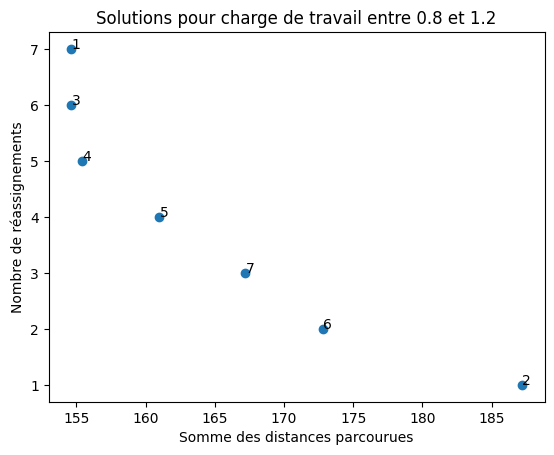

In [19]:
xpoints = np.array([solutions[k][1] for k in solutions])
ypoints = np.array([solutions[k][2] for k in solutions])

fig, ax = plt.subplots()
ax.scatter(xpoints, ypoints)
for i in range(len(solutions)):
    print(f"{i+1} : {xpoints[i]}, {ypoints[i]}")
    ax.annotate(str(i+1), (xpoints[i], ypoints[i]))

ax.set_xlabel("Somme des distances parcourues")
ax.set_ylabel("Nombre de réassignements")
ax.set_title("Solutions pour charge de travail entre 0.8 et 1.2")

plt.savefig("q1_q2.png")

# Q3

In [26]:
# Create linear solver
solver = pywraplp.Solver.CreateSolver("SCIP")
if not solver:
    print("Error during solver's creation")

In [27]:
# Values for constraints
epsilon = 1
min_workload = 0.9
max_workload = 1.1
init_state_matrix = create_init_assign_matrix(assignment)
index_value_matrix = create_index_value_matrix(workload)
distances_matrix = create_distances_matrix(distances)
hq_bricks = [[0,3],[1,13],[2,15],[3,21]]
num_sr = len(distances_matrix[0])
num_bricks = len(distances_matrix)

# Boolean variables
x = {}
for brick in range(num_bricks):
    for sr in range(num_sr):
        x[brick, sr] = solver.IntVar(0, 1, f"x[{brick},{sr}]")

# Add constraints
# One brick to one SR and one SR to one brick
for brick in range(num_bricks):
    solver.Add(solver.Sum(x[brick, sr] for sr in range(num_sr)) == 1)

# The cental brick for an SR cannot change
hq_vars = []
for hq in hq_bricks:
    hq_vars.append(x[hq[1],hq[0]])
solver.Add(solver.Sum(hq_vars) == num_sr)

# Balance workload (min and max)
for sr in range(num_sr):
    solver.Add(solver.Sum(index_value_matrix[brick][sr] * x[brick,sr] for brick in range(num_bricks)) >= min_workload)
    solver.Add(solver.Sum(index_value_matrix[brick][sr] * x[brick,sr] for brick in range(num_bricks)) <= max_workload)

In [28]:
solutions = {}
feasible = True
loop = 0
while feasible:
    if loop % 2:
        if loop != 0:
            solver.Add(solver.Sum((x[brick,sr] - 2*init_state_matrix[brick][sr]*x[brick,sr] + init_state_matrix[brick][sr]) * 1/2 for brick in range(num_bricks) for sr in range(num_sr)) <= solutions[loop-1][2] - epsilon)
        solver.Minimize(
            solver.Sum((x[brick,sr] - 2*init_state_matrix[brick][sr]*x[brick,sr] + init_state_matrix[brick][sr]) * 1/2  for brick in range(num_bricks) for sr in range(num_sr))
        )
    else:
        if loop != 0:
            solver.Add(solver.Sum(distances_matrix[brick][sr] * x[brick,sr] for sr in range(num_sr) for brick in range(num_bricks)) <= solutions[loop-1][1] - epsilon)
        solver.Minimize(
            solver.Sum(distances_matrix[brick][sr] * x[brick,sr] for sr in range(num_sr) for brick in range(num_bricks))
        )

    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        print(f"################## LOOP {loop + 1} ###################") 
        solution = [[x[brick,sr].solution_value() for sr in range(num_sr)] for brick in range(num_bricks)]
        print_reassignments(init_state_matrix, solution)
        print()
        print("======DISTANCES======")
        print_distance_by_sr(distances_matrix, solution)
        print()
        print("======WORKLOAD======")
        print_workload_by_sr(index_value_matrix, solution)
        print()
        print(f"Number of reassignments : {compute_reassignments(init_state_matrix, solution)}")
        print(f"Total distance : {compute_total_distances(distances_matrix, solution)}")
        print(f"Diff min max workload : {compute_diff_min_max_workload(index_value_matrix, solution)}")
        print()
        solutions[loop] = [solution, compute_total_distances(distances_matrix, solution), compute_reassignments(init_state_matrix, solution), compute_diff_min_max_workload(index_value_matrix, solution)]
    else:
        if status == 2:
            feasible = False
    loop += 1

################## LOOP 1 ###################
Brick 9 has changed from SR 3 to SR 1
Brick 10 has changed from SR 2 to SR 3
Brick 12 has changed from SR 2 to SR 1
Brick 15 has changed from SR 1 to SR 3
Brick 17 has changed from SR 3 to SR 2
Brick 19 has changed from SR 4 to SR 1

======DISTANCES======
SR 1 is travelling 46.88km
SR 2 is travelling 9.19km
SR 3 is travelling 7.0200000000000005km
SR 4 is travelling 99.34km

======WORKLOAD======
SR 1 is working 0.9379
SR 2 is working 1.073
SR 3 is working 1.0866
SR 4 is working 0.9025

Number of reassignments : 6.0
Total distance : 162.43
Diff min max workload : 0.18410000000000004

################## LOOP 2 ###################
Brick 10 has changed from SR 2 to SR 3

======DISTANCES======
SR 1 is travelling 19.3km
SR 2 is travelling 28.800000000000004km
SR 3 is travelling 14.36km
SR 4 is travelling 124.74000000000001km

======WORKLOAD======
SR 1 is working 0.9507
SR 2 is working 1.0848
SR 3 is working 0.9577
SR 4 is working 1.006800000000000

In [29]:
to_delete = []
for k in solutions:
    for j in solutions:
        if k != j:
            if solutions[j][1] < solutions[k][1] and solutions[j][2] < solutions[k][2]:
                print(f"{j} is better than {k} : {solutions[j][1]} < {solutions[k][1]} and {solutions[j][2]} < {solutions[k][2]}")
                to_delete.append(k)
            elif solutions[j][1] < solutions[k][1] and solutions[j][2] <= solutions[k][2]:
                print(f"{j} is better than {k} : {solutions[j][1]} < {solutions[k][1]} and {solutions[j][2]} <= {solutions[k][2]}")
                to_delete.append(k)
            elif solutions[j][1] <= solutions[k][1] and solutions[j][2] < solutions[k][2]:
                print(f"{j} is better than {k} : {solutions[j][1]} <= {solutions[k][1]} and {solutions[j][2]} < {solutions[k][2]}")
                to_delete.append(k)
for z in set(to_delete):
    solutions.pop(z)

In [30]:
for k in solutions:
    print(f"{k} : {solutions[k][-1]}")

0 : 0.18410000000000004
1 : 0.1341
2 : 0.18410000000000004
3 : 0.18230000000000002
4 : 0.15249999999999997


1 : 162.43, 6.0
2 : 187.20000000000002, 1.0
3 : 167.33, 5.0
4 : 172.93000000000004, 2.0
5 : 171.62, 4.0


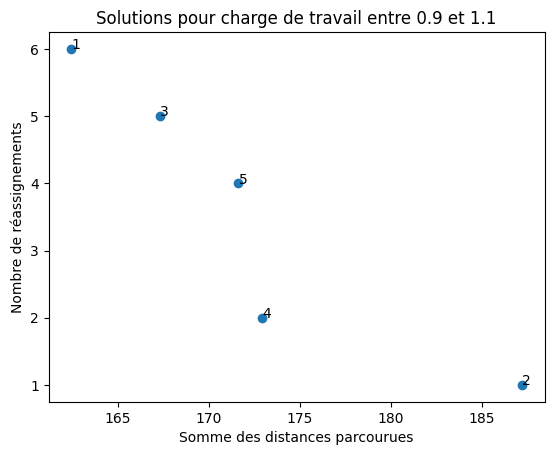

In [31]:
xpoints = np.array([solutions[k][1] for k in solutions])
ypoints = np.array([solutions[k][2] for k in solutions])

fig, ax = plt.subplots()
ax.scatter(xpoints, ypoints)
for i in range(len(solutions)):
    print(f"{i+1} : {xpoints[i]}, {ypoints[i]}")
    ax.annotate(str(i+1), (xpoints[i], ypoints[i]))

ax.set_xlabel("Somme des distances parcourues")
ax.set_ylabel("Nombre de réassignements")
ax.set_title("Solutions pour charge de travail entre 0.9 et 1.1")

plt.savefig("q3.png")

In [30]:
# Create linear solver
solver = pywraplp.Solver.CreateSolver("SCIP")
if not solver:
    print("Error during solver's creation")

In [39]:
# Values for constraints
epsilon = 0.1
min_workload = 0.8
max_workload = 1.2
init_state_matrix = create_init_assign_matrix(assignment)
index_value_matrix = create_index_value_matrix(workload)
distances_matrix = create_distances_matrix(distances)
hq_bricks = [[0,3],[1,13],[2,15],[3,21]]
num_sr = len(distances_matrix[0])
num_bricks = len(distances_matrix)

# Boolean variables
x = {}
for brick in range(num_bricks):
    for sr in range(num_sr):
        x[brick, sr] = solver.IntVar(0, 1, f"x[{brick},{sr}]")

# Add constraints
# One brick to one SR
for brick in range(num_bricks):
    solver.Add(solver.Sum(x[brick, sr] for sr in range(num_sr)) >= 1)
    solver.Add(solver.Sum(x[brick, sr] for sr in range(num_sr)) <= num_sr)

# The cental brick for an SR cannot change
hq_vars = []
for hq in hq_bricks:
    hq_vars.append(x[hq[1],hq[0]])
solver.Add(solver.Sum(hq_vars) == num_sr)

# Balance workload (min and max)
for sr in range(num_sr):
    solver.Add(solver.Sum(index_value_matrix[brick][sr] * x[brick,sr] for brick in range(num_bricks)) >= min_workload)
    solver.Add(solver.Sum(index_value_matrix[brick][sr] * x[brick,sr] for brick in range(num_bricks)) <= max_workload)

In [23]:
solutions = {}
feasible = True
loop = 0
while feasible:
    if loop % 2:
        if loop != 0:
            solver.Add(solver.Sum((x[brick,sr] - 2*init_state_matrix[brick][sr]*x[brick,sr] + init_state_matrix[brick][sr]) * 1/2 for brick in range(num_bricks) for sr in range(num_sr)) <= solutions[loop-1][2] - epsilon)
        solver.Minimize(
            solver.Sum((x[brick,sr] - 2*init_state_matrix[brick][sr]*x[brick,sr] + init_state_matrix[brick][sr]) * 1/2  for brick in range(num_bricks) for sr in range(num_sr))
        )
    else:
        if loop != 0:
            solver.Add(solver.Sum(distances_matrix[brick][sr] * x[brick,sr] for sr in range(num_sr) for brick in range(num_bricks)) <= solutions[loop-1][1] - epsilon)
        solver.Minimize(
            solver.Sum(distances_matrix[brick][sr] * x[brick,sr] for sr in range(num_sr) for brick in range(num_bricks))
        )

    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        print(f"################## LOOP {loop + 1} ###################") 
        solution = [[x[brick,sr].solution_value() for sr in range(num_sr)] for brick in range(num_bricks)]
        print_reassignments(init_state_matrix, solution)
        print()
        print("======DISTANCES======")
        print_distance_by_sr(distances_matrix, solution)
        print()
        print("======WORKLOAD======")
        print_workload_by_sr(index_value_matrix, solution)
        print()
        print(f"Number of reassignments : {compute_reassignments(init_state_matrix, solution)}")
        print(f"Total distance : {compute_total_distances(distances_matrix, solution)}")
        print()
        solutions[loop] = [solution, compute_total_distances(distances_matrix, solution), compute_reassignments(init_state_matrix, solution)]
    else:
        if status == 2:
            feasible = False
    loop += 1

################## LOOP 1 ###################
Brick 9 has changed from SR 3 to SR 1
Brick 11 has changed from SR 2 to SR 3
Brick 12 has changed from SR 2 to SR 1
Brick 15 has changed from SR 1 to SR 3
Brick 18 has changed from SR 3 to SR 2
Brick 19 has changed from SR 4 to SR 1

======DISTANCES======
SR 1 is travelling 53.53827444051826km
SR 2 is travelling 4.08031633056544km
SR 3 is travelling 9.500624752866747km
SR 4 is travelling 83.98914605418139km

======WORKLOAD======
SR 1 is working 1.0404
SR 2 is working 0.9595999999999999
SR 3 is working 1.2
SR 4 is working 0.8

Number of reassignments : 7.596929330019128
Total distance : 151.10836157813185



TypeError: 